## Closed Kinemtaic Chain hopper

In [1]:
# EOMs
%reset
#import libraries
import sympy as sym
import numpy as np
import pickle as pickle

sym.init_printing()
from IPython.display import display #for pretty printing

# Symbols --------------------------------------------------
links = ['b','l1R','l1L','l2R','l2L']

#Parameters
m = {}
L = {}
I = {}
d = {}
g = sym.symbols('g')

for l in links:
    m.update({l: sym.symbols('m_{%s}'%l)})
    L.update({l: sym.symbols('L_{%s}'%l)})
    I.update({l: sym.symbols('I_{%s}'%l)})
    d.update({l: sym.symbols('d_{%s}'%l)})

#gen coordinates
x,y,thb = sym.symbols(['x','y','\\theta_{b}'])
dx,dy,dthb = sym.symbols(['\\dot{x}','\\dot{y}','\\dot{\\theta}_{b}'])
ddx,ddy,ddthb = sym.symbols(['\\ddot{x}','\\ddot{y}','\\ddot{\\theta}_{b}'])

th = {}
dth = {}
ddth = {}

for l in links[1:]:
    th.update({l: sym.symbols('\\theta_{%s}'%l)})
    dth.update({l: sym.symbols('\\dot{\\theta}_{%s}'%l)})
    ddth.update({l: sym.symbols('\\ddot{\\theta}_{%s}'%l)})

q = sym.Matrix([y]+[th[l] for l in links[1:]])
dq = sym.Matrix([dy]+[dth[l] for l in links[1:]])
ddq = sym.Matrix([ddy]+[ddth[l] for l in links[1:]])

# positions
def get_R(th_in):    
    Rz = sym.Matrix([[sym.cos(th_in),-sym.sin(th_in),0],
                    [sym.sin(th_in),sym.cos(th_in),0],
                    [0,0,1]])
    
    R = Rz
    return R

pt = {'b': sym.Matrix([[0],[y],[0]])}
po = {'b': sym.Matrix([[0],[0],[0]])}

for l in links[1:]:
    po.update({l: sym.Matrix([[0],[0],[th[l]]])})

sides = ['R','L']

kneep = {}

footp = {}
footv = {}
foota = {}

for s in sides:
    R1 = get_R(th['l1%s'%s])
    pt.update({'l1%s'%s: pt['b'] + R1*sym.Matrix([[0],[-0.5*L['l1%s'%s]],[0]])})
    kneep.update({s: pt['b'] + R1*sym.Matrix([[0],[-L['l1%s'%s]],[0]])})
    
    R2 = get_R(th['l2%s'%s])
    pt.update({'l2%s'%s: kneep[s] + R2*sym.Matrix([[0],[-d['l2%s'%s]*L['l1%s'%s]],[0]])})
    
    footp.update({s: kneep[s] + R2*sym.Matrix([[0],[-L['l2%s'%s]],[0]])})
    footv.update({s: footp[s].jacobian(q)*dq})
    foota.update({s: footv[s].jacobian(q)*dq + footp[s].jacobian(q)*ddq})
    
p = {}
v = {}
J = {}
for l in links:
    p.update({l: sym.Matrix([pt[l],po[l]])})
    v.update({l: p[l].jacobian(q)*dq})
    J.update({l: v[l].jacobian(dq)})
    
# ENERGY ---------------------------------------------------------------------------------------
T = sum([0.5*m[l]*(v[l][0]**2 + v[l][1]**2) for l in links]) + sum([0.5*I[l]*v[l][5]**2 for l in links])
V = sum([m[l]*g*p[l][1] for l in links])

# term 1
Lg1 = sym.zeros(len(q),1)
for i in range(len(q)):
    dT_ddq = sym.Matrix([sym.diff(T,dq[i])]) # get partial of T in dq_i
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq #...then get time derivative of that partial

# term 3
Lg3 = sym.Matrix([T]).jacobian(q).transpose() # partial of T in q

# term 4
Lg4 = sym.Matrix([V]).jacobian(q).transpose() # partial of U in q

#GEN FORCES-----------
# constraint forces
dj = sym.symbols('d_j')
FcxR, FcyR, FcxL, FcyL = sym.symbols(['F_{cxR}','F_{cyR}','F_{cxL}','F_{cyL}'])

FcL = sym.Matrix([[FcxL],[FcyL],[0]])
FcL_r = footp['L']
FcL_Q = FcL_r.jacobian(q).transpose()*FcL

FcR = sym.Matrix([[FcxR],[FcyR],[0]])
FcR_r = kneep['R'] + get_R(th['l2R'])*sym.Matrix([[0],[-dj],[0]])
FcR_Q = FcR_r.jacobian(q).transpose()*FcR

jointp = {'L': FcL_r, 'R': FcR_r}
jointv = {}
jointa = {}
for s in sides:
    jointv.update({s: jointp[s].jacobian(q)*dq})
    jointa.update({s: jointv[s].jacobian(q)*dq + jointv[s].jacobian(dq)*ddq})
# ground reaction force
Gx, Gy = sym.symbols(['G_x','G_y'])

G = sym.Matrix([[Gx],[Gy],[0]])
G_r = footp['R']
G_Q = G_r.jacobian(q).transpose()*G

# actuators
tau = {}
for s in sides:
    tau.update({s: sym.symbols('\\tau_{%s}'%s)})

tau_Q = sym.Matrix([[0],[tau['R']],[tau['L']],[0],[0]])

Q = FcL_Q + FcR_Q + G_Q + tau_Q

# AND combine!
EOM = Lg1 - Lg3 + Lg4 - Q

In [2]:
# LAMBDIFY
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g] + [m[l] for l in links] +\
           [L[l] for l in links] +\
           [I[l] for l in links] +\
           [d[l] for l in links] + [dj] +\
           [y] + [th[l] for l in links[1:]] +\
           [dy] + [dth[l] for l in links[1:]] +\
           [ddy]+ [ddth[l] for l in links[1:]] +\
           [tau['R'],tau['L'],Gx,Gy,FcxR, FcyR, FcxL, FcyL]

lamb_EOM = {}

DOFs = ['y'] + ['th_%s'%l for l in links[1:]]

for dof_i,dof in enumerate(DOFs):
    lamb_EOM.update({dof: sym.lambdify(sym_list,EOM[dof_i],modules = [func_map])})

TDOFs = ['x','y']
lamb_footp = {}
lamb_footv = {}
for dof_i,dof in enumerate(TDOFs):
    lamb_footp.update({dof: sym.lambdify(sym_list,footp['R'][dof_i],modules = [func_map])})
    lamb_footv.update({dof: sym.lambdify(sym_list,footv['R'][dof_i],modules = [func_map])})

lamb_jointp = {}
lamb_jointv = {}
lamb_jointa = {}
for s in sides:
    for dof_i,dof in enumerate(TDOFs):
        lamb_jointp.update({(s,dof): sym.lambdify(sym_list,jointp[s][dof_i],modules = [func_map])})
        lamb_jointv.update({(s,dof): sym.lambdify(sym_list,jointv[s][dof_i],modules = [func_map])})
        lamb_jointa.update({(s,dof): sym.lambdify(sym_list,jointa[s][dof_i],modules = [func_map])})

In [3]:
# PARAMETERS:
mass = {'b': 2.8 + 2.542,
       'l1R': 0.079,
       'l1L': 0.079,
       'l2R': 0.101,
       'l2L': 0.100}

length = {'b': 0,
         'l1R': 0.1375,
         'l1L': 0.1375,
         'l2R': 0.289,
         'l2L': 0.250}

inertia = {'b': 0,
          'l1R': 157713/(1000*1000**2),
          'l1L': 157713/(1000*1000**2),
          'l2R': 927418/(1000*1000**2),
          'l2L': 817690/(1000*1000**2)}

In [4]:
def get_var_list(m,n):
    var_list = [m.g]+\
                [m.m[l] for l in links]+\
                [m.l[l] for l in links]+\
                [m.I[l] for l in links]+\
                [m.dCOM[l] for l in links]+[m.dj]+\
                [m.q[n,dof] for dof in DOFs]+\
                [m.dq[n,dof] for dof in DOFs]+\
                [m.ddq[n,dof] for dof in DOFs]+\
                [m.tau[n,s] for s in sides]+\
                [m.GRF[n,dof] for dof in TDOFs]+\
                [m.Fc[n,s,dof] for s in sides for dof in TDOFs]
    return var_list

def create_model(N,hm,mu):
    m = ConcreteModel()
    
    #SETS-------------------------
    m.N =RangeSet(N)
    m.L =Set(initialize = links)
    m.DOF = Set(initialize= DOFs)
    m.TDOF = Set(initialize = TDOFs)
    m.S=Set(initialize = sides)
    
    #Params--------------------------
    m.g = Param(initialize = 9.81)
    m.m = Param(m.L, initialize = mass)
    m.l = Param(m.L, initialize = length)
    m.I = Param(m.L, initialize = inertia)
    m.dCOM = Param(m.L, initialize = 0.5)
    m.dj = Param(initialize = length['l2L'])
    signs = ['ps','ng']
    m.sgn = Set(initialize = signs)
    #VARIABLES----------------------
    #gen coordinates
    m.q = Var(m.N,m.DOF)
    m.dq = Var(m.N,m.DOF)
    m.ddq = Var(m.N,m.DOF)
    
    for n in range(1,N+1):
        for l in links:
            m.q[n,'y'].setlb(0.0)
            m.q[n,'th_l1R'].setlb(np.pi/18)
            m.q[n,'th_l1R'].setub(5*np.pi/6)
            m.q[n,'th_l1L'].setlb(-5*np.pi/6)
            m.q[n,'th_l1L'].setub(-np.pi/18)
    
    #forces
    m.tau = Var(m.N,m.S)
    m.Fc = Var(m.N,m.S,m.TDOF)
    m.GRF = Var(m.N, m.TDOF)
    
    for n in range(1,N+1):
        m.GRF[n,'y'].setlb(0)
    #TIME AND INTEGRATION ---------------------------------------------------------------------------------------------------

    # timestep
    m.hm = Param(initialize = hm, mutable = True) # master timestep
    m.h = Var(m.N, bounds = (0.8,1.2))
    
    # Integration constraints 
    def BwEuler_p(m,n,dof): # for positions
        if n > 1:
            return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
        else:
            return Constraint.Skip 
    m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

    def BwEuler_v(m,n,dof): # for velocities
        if n > 1:
            return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n-1,dof]
        else:
            return Constraint.Skip 
    m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)
    
    def dynamics(m,n,dof):
        var_list = get_var_list(m,n)
        return lamb_EOM[dof](*var_list) == 0
    m.dynamic = Constraint(m.N,m.DOF, rule = dynamics)
    
    # motor model --------------------------------------------------------------------------------------
    max_rpm = (80*48)/2
    max_dth = max_rpm*2*np.pi/60
    max_tau = 8.92*2
    
    for n in range(1,N+1):
        for s in sides:
            m.tau[n,s].setlb(-max_tau)
            m.tau[n,s].setub(max_tau)
            # m.dq[n,'th_l1%s'%s].setlb(-max_dth/2)
            # m.dq[n,'th_l1%s'%s].setub(max_dth/2)
    
    def speed_bounds(omega):
            ub =(-(max_tau)/(max_dth))*omega + max_tau
            lb = (-(max_tau)/(max_dth))*omega - max_tau
            return(lb,ub)
            
    def motor_torque_speed_curve(m,n,s,sgn):
        lb,ub = speed_bounds(m.dq[n,'th_l1R'])
        if sgn == 'ps':
            for s in sides:
                return m.tau[n,'%s'%s] <= ub
        else:
            for s in sides:
                return m.tau[n,'%s'%s] >= lb
        return Constraint.Skip
    m.motor_torque_speed_curve = Constraint(m.N, m.S, m.sgn, rule = motor_torque_speed_curve)
    
    # connection -------------------------------------------------------------------------------------
    m.jointp = Var(m.N, m.S, m.TDOF)
    def get_jointp(m,n,s,dof):
        var_list = get_var_list(m,n)
        return m.jointp[n,s,dof] == lamb_jointp[s,dof](*var_list)
    m.get_jointp = Constraint(m.N, m.S, m.TDOF, rule = get_jointp)
    
    def constraint_forces(m,n,dof):
        return m.Fc[n,'L',dof] == -m.Fc[n,'R',dof]
    m.constraint_forces = Constraint(m.N,m.TDOF, rule = constraint_forces)
    
    def connect_p(m,n,dof):
        return m.jointp[n,'R',dof] == m.jointp[n,'L',dof]
    m.connect_p = Constraint(m.N,m.TDOF, rule = connect_p)
    
    #GROUND -------------------------------------------------
    
    
    m.footp = Var(m.N,m.TDOF, bounds = (0.0,None))
    def def_footp(m,n,dof):
        if dof == 'x':
            return Constraint.Skip
        else:
            var_list = get_var_list(m,n)
            return m.footp[n,dof] == lamb_footp[dof](*var_list)
    m.def_footp = Constraint(m.N, m.TDOF, rule = def_footp)
        
    m.footv = Var(m.N, m.TDOF)
    def def_footv(m,n,dof):
        if dof == 'y': return Constraint.Skip
        else:
             var_list = get_var_list(m,n)
        return m.footv[n,dof] == lamb_footv[dof](*var_list)
    m.def_footv = Constraint(m.N, m.TDOF, rule = def_footv)
    
    m.contact_penalty = Var(m.N, bounds = (0.0,None))
    def contact_complementarity(m,n):
        if n<N:
            return m.footp[n+1,'y']*m.GRF[n,'y']<=m.contact_penalty[n] 
        else:
            return m.footp[n,'y']*m.GRF[n,'y']<=m.contact_penalty[n] 
    m.contact_complementarity = Constraint(m.N, rule = contact_complementarity)
    
    #friction
    m.mu = Param(initialize = mu)
    
    GDOFs = ['x']
    m.GDOF = Set(initialize = GDOFs)
    d_res = 2
    directions = RangeSet(d_res)
    m.D = Set(initialize = directions) #directions
    def get_d(m,dof,d):
        th = np.linspace(0,2*np.pi,d_res+1)
        if dof == 'x':
            return np.cos(th[d-1])
        if dof == 'z':
            return np.sin(th[d-1])
    m.d = Param(m.GDOF, m.D, initialize = get_d) # unit vectors
    
    m.alpha = Var(m.N, m.D, bounds = (0,1))
    m.F = Var(m.N, bounds = (0,None)) #friction force
    m.gamma = Var(m.N, bounds = (0,None))
    m.dir = Var(m.N, m.D, bounds = (0,None))
    
    def def_gamma(m,n,d):
        dx = m.footv[n,'x']
        return m.gamma[n] + sum([m.d[dof,d]*dx for dof in GDOFs]) == m.dir[n,d]
    m.def_gamma = Constraint(m.N,m.D, rule = def_gamma)
    
    def friction(m,n): # insert velocity-dependent friction law here
        dx = m.footv[n,'x']
        fm = m.mu
        return m.F[n] == fm*m.GRF[n,'y']
    m.friction = Constraint(m.N, rule = friction)

    def get_GRF(m,n,dof):
        return m.GRF[n,dof] == m.F[n]*sum([m.alpha[n,d]*m.d[dof,d] for d in directions])
    m.get_GRF = Constraint(m.N, m.GDOF, rule = get_GRF)

    # complementarity
    m.direction_penalty = Var(m.N, m.D, bounds = (0.0,None))
    m.magnitude_penalty = Var(m.N, bounds = (0,None))

    def direction_complementarity(m,n,d):
        A = m.alpha[n,d]
        B = m.dir[n,d]
        return  A*B <= m.direction_penalty[n,d]
    m.direction_complementarity = Constraint(m.N, m.D, rule = direction_complementarity)

    def magnitude_complementarity(m,n):
        A = m.gamma[n]
        B = 1-sum([m.alpha[n,d] for d in directions])
        return A*B <= m.magnitude_penalty[n]
    m.magnitude_complementarity = Constraint(m.N, rule = magnitude_complementarity)
    
    def MinPenalty(m):
        return sum([m.contact_penalty[n] + m.magnitude_penalty[n] for n in range(1,N+1)]) +\
                sum([m.direction_penalty[n,d] for n in range(1,N+1) for d in range(1,d_res+1)])#+\
                #sum([m.tau[n,s]**2 for n in range(1,N+1) for s in sides])
    m.MinPenalty = Objective(rule = MinPenalty)
    m.MinPenalty.deactivate()
    
    def CostFun(m):
        pen_sum = sum(m.contact_penalty[:]) + sum(m.magnitude_penalty[:]) + sum(m.direction_penalty[:,:])
        torque_sum = 0
        for n in range(1,N+1):
            for s in sides:
                torque_sum += m.tau[n,s]**2
        return pen_sum#+torque_sum
    m.Cost = Objective(rule = CostFun)
    #m.Cost.deactivate()

    def body_foot(m,n):
        return m.footp[n,'y'] - m.q[n,'y'] >= -0.4

    m.body_foot = Constraint(m.N, rule = body_foot)
    
    def ss_p(m,dof):
        #if dof != 'y': return Constraint.Skip
        return m.q[1,dof] == m.q[N,dof]
    m.ss_p = Constraint(m.DOF, rule = ss_p)
    
    def ss_v(m,dof):
        return m.dq[1,dof] == m.dq[N,dof]
    m.ss_v = Constraint(m.DOF, rule = ss_v)
    
    def MaxHeight(m):
        return -m.q[1,'y']
    m.MaxHeight = Objective(rule = MaxHeight)
    m.MaxHeight.deactivate()
    
    return m

In [5]:
def init_opt(): # initializes solver
    opt = SolverFactory('ipopt',executable = '/home/immanuel/Solver/build/bin/ipopt')
    opt.options["linear_solver"] = 'ma86'
    opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
    opt.options["max_iter"] = 30000 # maximum number of iterations
    opt.options["max_cpu_time"] = 3600 # maximum cpu time in seconds
    opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
    opt.options["OF_acceptable_obj_change_tol"] = 1e-4
    opt.options["OF_ma86_scaling"] = 'none'
    
    return opt

In [17]:
N = 100+1
hm = 0.01
mu = 1.0
m = create_model(N,hm,mu)
# # HIGH DROP -----------------------------------------------------------------------------------------------------------------

m.footp[1,'y'].fix(0)
m.q[1,'y'].setlb(0.2)
#m.q[1,'x'].fix(0)
#m.q[1,'th_b'].fix(0)
#m.footp[1,'y'].fix(0)
#rest pose
m.dq[1,:].fix(0)
m.h[1].fix(1)

#final
#m.q[N,'x'].setlb(1)
#m.q[N,'y'].setlb(0.9)
#m.footp[N,'x'].setlb(0)
#m.footp[N,'y'].fix(0)
#m.q[N,'th_b'].fix(0)
#m.dq[N,:].fix(0)
#set initial pose


# m.footp[0.5*(N-1),'y'].setlb(0.2)
m.q[0.5*(N-1),'y'].setlb(0.6)
#m.footp[0.5*(N-1),'x'].fix(0)
# m.q[0.5*]
for n in range(1,N+1):
    m.footp[n,'x'].fix(0)
# m.footp[0.5*(N-1),'x'].setub(0.01)


opt = init_opt()

results = opt.solve(m,tee = True)

Ipopt 3.14.4: linear_solver=ma86
print_level=5
max_iter=30000
max_cpu_time=3600
Tol=1e-06
option_file_name=/tmp/tmpr9jj6dvo_ipopt.opt

Using option file "/tmp/tmpr9jj6dvo_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    14594
Number of nonzeros in inequality constraint Jacobian.:     2117
Number of nonzeros in Lagrangian Hessian.............:     6937

Total number of variables............................:     4033
                     variables with only lower bounds:     1110
                variables with lower and upp

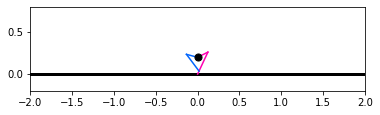

In [18]:
#animate it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
from matplotlib.animation import FuncAnimation, FFMpegWriter
import numpy as np
%matplotlib inline
#matplotlib.use('WebAgg')

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')


ymax = np.max([m.q[n,'y'].value for n in range(1,N+1)])
# time = [0]
# time.append(time[n-1]+hm*m.h[n].value)
# time.pop()

# ax.plot(time,m.GRF[n,'y'].value )

def plot_model(n,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-2, 2])
    ax.set_ylim([-0.2, ymax + 0.2])
    ax.plot([-10,10],[0,0],linewidth=3,color='black')
    p = 0
    
    y = m.q[n,'y'].value
    
    
    #plot body
    #body_xb = x - 0.5*m.l['b']*cos(m.q[n,'th_b'].value)
    #body_yb = y - 0.5*m.l['b']*sin(m.q[n,'th_b'].value)
    #body_xf = x + 0.5*m.l['b']*cos(m.q[n,'th_b'].value)
    #body_yf = y + 0.5*m.l['b']*sin(m.q[n,'th_b'].value)
    ax.scatter([0],[y],s=50,color='black',zorder=50)
    #ax.plot([body_xb,body_xf],[body_yb,body_yf],linewidth = 3,color='xkcd:black')
    
    cols = ['xkcd:bright pink','xkcd:bright blue']
    for si, s in enumerate(sides):
        l1 = m.l['l1%s'%s]
        th1 = m.q[n,'th_l1%s'%s].value
        knee_x = l1*np.sin(th1)
        knee_y = y-l1*np.cos(th1)
        ax.plot([0,knee_x],[y,knee_y],color=cols[si])
        
        l2 = m.l['l2%s'%s]
        th2 = m.q[n,'th_l2%s'%s].value
        foot_x = knee_x + l2*np.sin(th2)
        foot_y = knee_y - l2*np.cos(th2)
        ax.plot([knee_x,foot_x],[knee_y,foot_y],color=cols[si])
        
       
update = lambda n: plot_model(n,m,ax1) #lambdify update function

animate = FuncAnimation(fig1,update,range(1,N+1),interval = 100,repeat=True)
writer = FFMpegWriter(fps=1.0/0.1, metadata=dict(artist='Me'))
animate.save('hop_animation.mp4', writer=writer)

#HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook

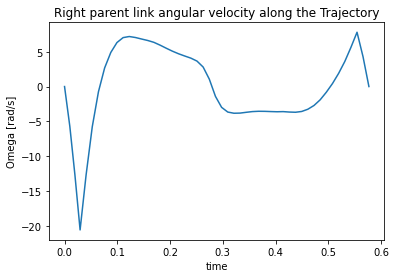

In [93]:
import pandas as pd


# Plotfig2, 
fig2, ax2 = plt.subplots(1,1)
time = [0]
for n in range(1,N+1): time.append(time[n-1] + hm*m.h[n].value)
time.pop()
dt = [m.h[n].value for n in range(1,N+1)]
m.h[1].value = 1.0 # left out of integrationtime_sum = hm*sum(model.h[n].value for n in nodes)
#print(f'Duration: {time_sum}s')
#ax2.plot(time, [m.GRF[n,'y'].value for n in m.N])
ax2.plot(time, [m.dq[n,'th_l1R'].value for n in m.N])
ax2.set_xlabel('time')
ax2.set_ylabel('Omega [rad/s]')
ax2.set_title('Right parent link angular velocity along the Trajectory')


foot_pos = [m.q[n,'y'].value for n in m.N]
body_x = [m.q[n,'y'].value for n in m.N]
t = np.array(time)
f = np.array(foot_pos)
x = np.array(body_x)
df = pd.DataFrame({"time":t, "input_y":f, "input_x":x}) 
df.to_csv("monopodData_0.6.csv",index = False)